10.1 Using the formulation in Section10.3,plot the betsize(m) as a function of the
maximum predicted probability $\~{p}$ when ||X||=2,3,...,10

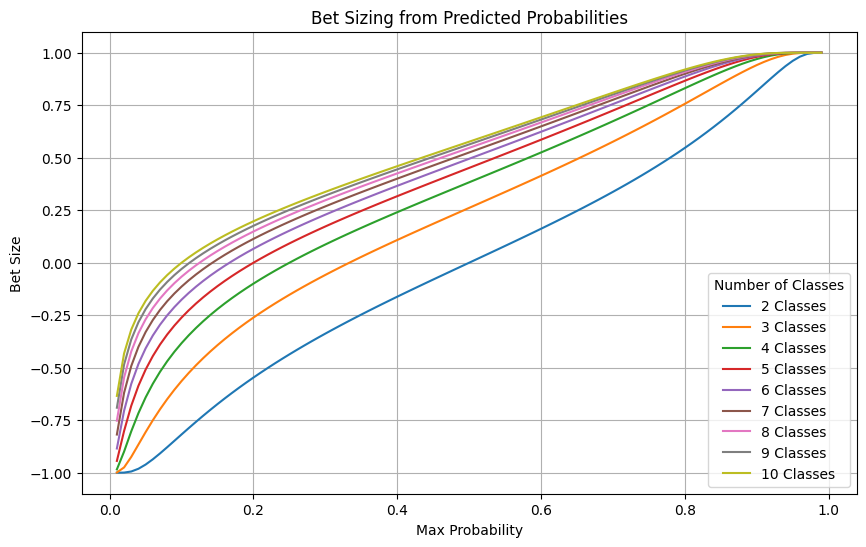

In [1]:
# bet sizing from predicted probabilities
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
max_p_range=np.arange(0.01, 1, 0.01)
def get_bet_distribution(num_classes):
    ret=[]
    for max_p in max_p_range:
        t_value=(max_p-1/num_classes)/np.sqrt((max_p*(1-max_p)))
        bet_size=2*norm.cdf(t_value)-1
        ret.append(bet_size)
    return ret

df={i: get_bet_distribution(i) for i in range(2, 11)}
df=pd.DataFrame.from_dict(df)

plt.figure(figsize=(10, 6))
plt.title('Bet Sizing from Predicted Probabilities')
plt.xlabel('Max Probability')
plt.ylabel('Bet Size')
for i in range(2, 11):
    plt.plot(max_p_range, df[i], label=f'{i} Classes')
plt.legend(title='Number of Classes')
plt.grid()
plt.show()



10.2 Draw 10,000 random numbers from a uniform distribution with bounds
U[0.5, 1.0].   
(a) Compute the bet sizes m for ||X||=2

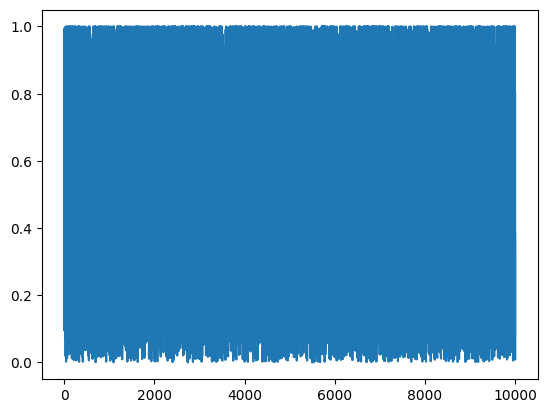

In [2]:
X=pd.DataFrame()
X['prob']=np.random.uniform(0.5, 1.0, 10000)
X['z_score']=X['prob'].apply(lambda prob: (prob-0.5)/(np.sqrt(prob*(1-prob))))
X['bet_size']=X['z_score'].apply(lambda z: 2*norm.cdf(z)-1)
plt.plot(X.index, X['bet_size'], label='bet_size')
plt.show()


(b) Assign 10000 consecutive calendar days to the bet sizes.

In [3]:
from datetime import datetime
X.index=pd.date_range(end=datetime.now(),  periods=len(X.index), freq='1D').normalize()

(c) Draw 10,000 random numbers from a uniform distribution with bounds U[1,25].  

In [4]:
shift_days=np.random.randint(1, 26, 10000)

(d) Form a pandas series indexed by the dates in 2.b, and with values equal  
to the index shifted forward the number of days in 2.c. This is a t1 object  
similartotheones we usedinChapter 3.  

In [5]:
X['t1']=pd.to_datetime(X.index) + pd.to_timedelta(shift_days, unit='D')

(e) Compute theresulting average active bets, following Section 10.4.

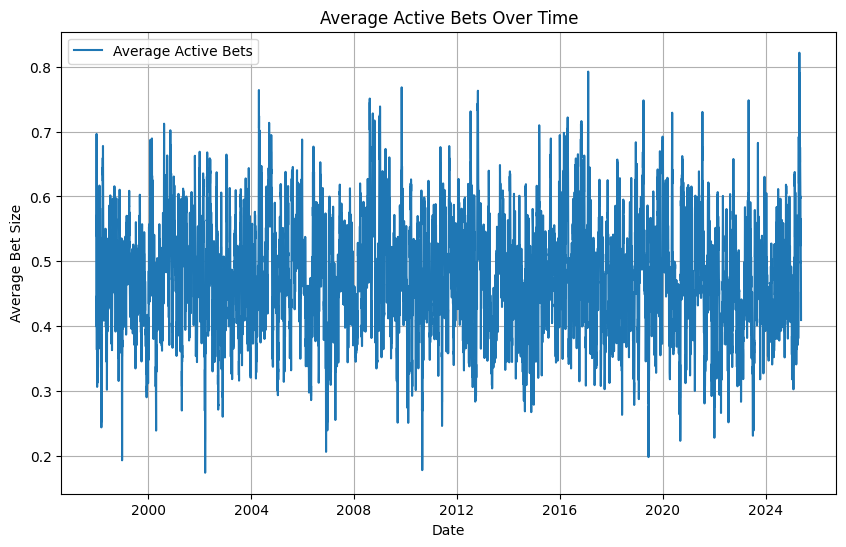

In [6]:
# avergeing active bets
def get_avg_active_bets(df):
    total_times=set(df['t1'].dropna().values)
    total_times=total_times.union(df.index)
    total_times=sorted(list(total_times))
    out=pd.Series()
    for loc in total_times:
        mask=((df.index.values<=loc) & (loc<df['t1'])) | pd.isnull(df['t1'])
        active=df.loc[mask].index
        if len(active)>0:
            out[loc]=df.loc[active, 'bet_size'].mean()
        else:
            out[loc]=0
    return out
X['avg_active_bets']=get_avg_active_bets(X)
plt.figure(figsize=(10, 6))
plt.title('Average Active Bets Over Time')
plt.xlabel('Date')
plt.ylabel('Average Bet Size')
plt.plot(X.index, X['avg_active_bets'], label='Average Active Bets')
plt.legend()
plt.grid()
plt.show()



10.3 Using the t1 object from exercise 2.d:  
(a) Determine the maximum number of concurrent long bets, $\bar{c_l}$.

현재 확률상 모든 배팅이 long이므로 uniform의 범위를 변경해서 short bet이 나올 수 있도록 변경하고 진행

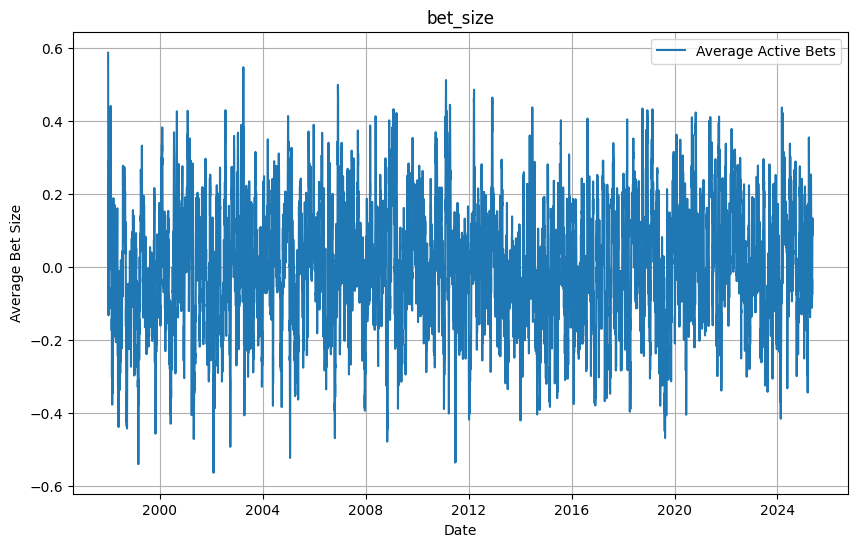

In [7]:
X=pd.DataFrame()
X['prob']=np.random.uniform(1e-6, 1.0, 10000)
X.index=pd.date_range(end=datetime.now(),  periods=len(X.index), freq='1D').normalize()
X['z_score']=X['prob'].apply(lambda prob: (prob-0.5)/(np.sqrt(prob*(1-prob))))
X['bet_size']=X['z_score'].apply(lambda z: 2*norm.cdf(z)-1)
X['t1']=pd.to_datetime(X.index)+pd.to_timedelta(shift_days, unit='D')
X['avg_active_bets']=get_avg_active_bets(X)
plt.figure(figsize=(10, 6))
plt.title('bet_size')
plt.xlabel('Date')
plt.ylabel('Average Bet Size')
plt.plot(X.index, X['avg_active_bets'], label='Average Active Bets')
plt.legend()
plt.grid()
plt.show()

In [8]:
# maximum number of concurrent bets
def get_max_concurrent_bets(df, sign=1):
    total_times=set(df['t1'].dropna().values)
    total_times=total_times.union(df.index)
    total_times=sorted(list(total_times))
    ret=0
    for loc in total_times:
        mask=((df.index.values<=loc) & (loc<df['t1'])) | pd.isnull(df['t1'])
        active=df.loc[mask].index
        if len(active)>0:
            ret=max(ret, (np.sign(df.loc[active, 'bet_size'])==sign).sum())
    return ret
max_current_long_bets=get_max_concurrent_bets(X, sign=1)
print(f'Maximum Number of Concurrent Long Bets: {max_current_long_bets}')

Maximum Number of Concurrent Long Bets: 14


(b) Determine the maximum number of concurrent shortbets,  $\bar{c_s}$.

In [9]:
max_current_short_bets=get_max_concurrent_bets(X, sign=-1)
print(f'Maximum Number of Concurrent Short Bets: {max_current_short_bets}')

Maximum Number of Concurrent Short Bets: 15


(c) Derive the bet size as $m_t=c_{t,l}\frac{1}{\bar{c_l}}-c_{t,s}\frac{1}{\bar{c_s}}$   
where $c_{t,l}$ is the number of concurrent long bets at time t, and $c_{t,s}$   
is the number of concurrent shortbets at time t.

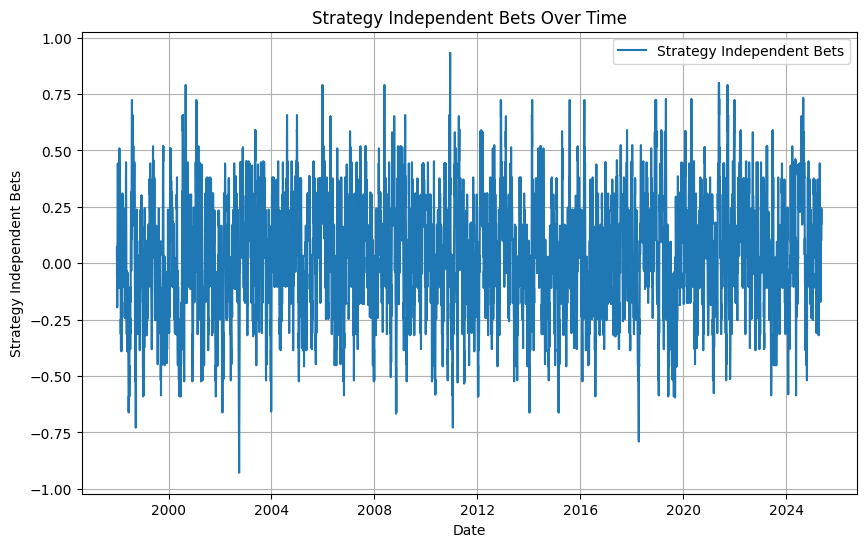

In [10]:
def get_strategy_independent_bets(df, max_long_current_bets, max_short_current_bets):
    total_times=set(df['t1'].dropna().values)
    total_times=total_times.union(df.index)
    total_times=sorted(list(total_times))
    out=pd.Series()
    for loc in total_times:
        mask=((df.index.values<=loc) & (loc<df['t1'])) | pd.isnull(df['t1'])
        active=df.loc[mask].index
        if len(active)>0:
            long_bets=(np.sign(df.loc[active, 'bet_size'])==1).sum()/max_long_current_bets
            short_bets=(np.sign(df.loc[active, 'bet_size'])==-1).sum()/max_short_current_bets
            out[loc]=long_bets-short_bets
        else:
            out[loc]=0
    return out
X['strategy_independent_bets']=get_strategy_independent_bets(X, max_current_long_bets, max_current_short_bets)
plt.figure(figsize=(10, 6))
plt.title('Strategy Independent Bets Over Time')
plt.xlabel('Date')
plt.ylabel('Strategy Independent Bets')
plt.plot(X.index, X['strategy_independent_bets'], label='Strategy Independent Bets')
plt.legend()
plt.grid()
plt.show()

10.4 Using the t1 object from exercise 2.d:   
(a) Compute the series $c_t = c_{t,l}−c_{t,s}$ where $c_{t,l}$ is the number of concurrent   
long bets at time t, and $c_{t,s}$ is the number of concurrent shortbets at time t.   

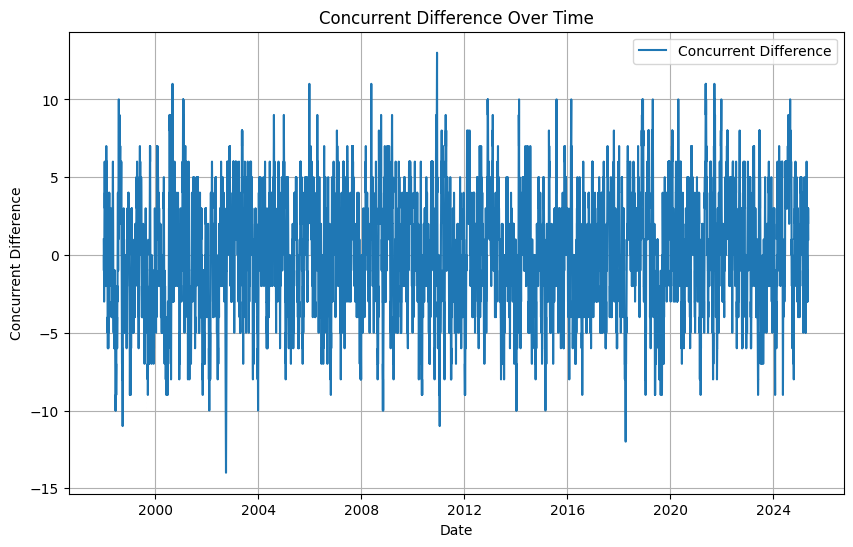

In [11]:
def get_concurrent_diff(df):
    total_times=set(df['t1'].dropna().values)
    total_times=total_times.union(df.index.values)
    total_times=sorted(list(total_times))
    out=pd.Series()
    for loc in total_times:
        mask=((df.index.values<=loc) & (loc<df['t1'])) | pd.isnull(df['t1'])
        active=df.loc[mask].index
        if len(active)>0:
            long_bets=(np.sign(df.loc[active, 'bet_size'])==1).sum()
            short_bets=(np.sign(df.loc[active, 'bet_size'])==-1).sum()
            out[loc]=long_bets-short_bets
        else:
            out[loc]=0
    return out
X['concurrent_diff']=get_concurrent_diff(X)
plt.figure(figsize=(10, 6))
plt.title('Concurrent Difference Over Time')
plt.xlabel('Date')
plt.ylabel('Concurrent Difference')
plt.plot(X.index, X['concurrent_diff'], label='Concurrent Difference')
plt.legend()
plt.grid()
plt.show()

(b) Fit a mixture of two Gaussians on {$c_t$}. 
You may want to use the method described in L´ opez de Prado and Foreman [2014].

In [26]:
from ef3m import EF3M
from scipy.stats import norm

con_diff=X['concurrent_diff']
moments=[np.mean(con_diff**i) for i in range(1, 6)]
ef3m=EF3M(tol=1e-4)
mu_1, sigma_1, mu_2, sigma_2, p_1 = ef3m.fit(moments)
mixture_cdf=lambda x: p_1*norm.cdf(x, mu_1, sigma_1) + (1-p_1)*norm.cdf(x, mu_2, sigma_2)



/Users/kimjuho/Desktop/quant/AFML/chapter10/ef3m.py:119: RuntimeWarning: invalid value encountered in scalar power
  sigma_2 = (


(c) Derive the bet size as $m_t=\begin{cases}\frac{F[c_t]-F[0]}{1-F[0]}\  if\ c_t \ge 0 \\ \frac{F[c_t]-F[0]}{F[0]}\  if\ c_t < 0\end{cases}$,   
where F[x] is the CDF of the fitted mixture of two Gaussians for a value x  

-4.477743583067335 6.688122783974972 0.5873621485423125 3.406515894707161 0.007103261015068497


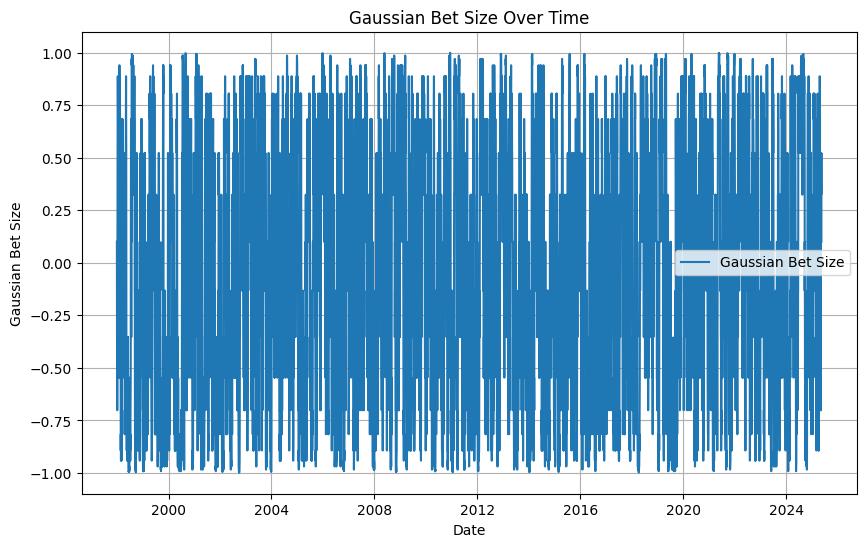

In [30]:
print(mu_1, sigma_1, mu_2, sigma_2, p_1)
X['gaussian_bet_size']=X['concurrent_diff'].apply(lambda x: 2*mixture_cdf(x)-1)
plt.figure(figsize=(10, 6))
plt.title('Gaussian Bet Size Over Time')
plt.xlabel('Date')
plt.ylabel('Gaussian Bet Size')
plt.plot(X.index, X['gaussian_bet_size'], label='Gaussian Bet Size')
plt.legend()
plt.grid()
plt.show()

(d) Explain how this series ${m_t}$ differ from the bet size series computed in
exercise 3.  
skew나 kurtosis를 보았을때 gaussian mixture가 좀 더 극단값을 잘 포착하는 것을 알 수 있다.


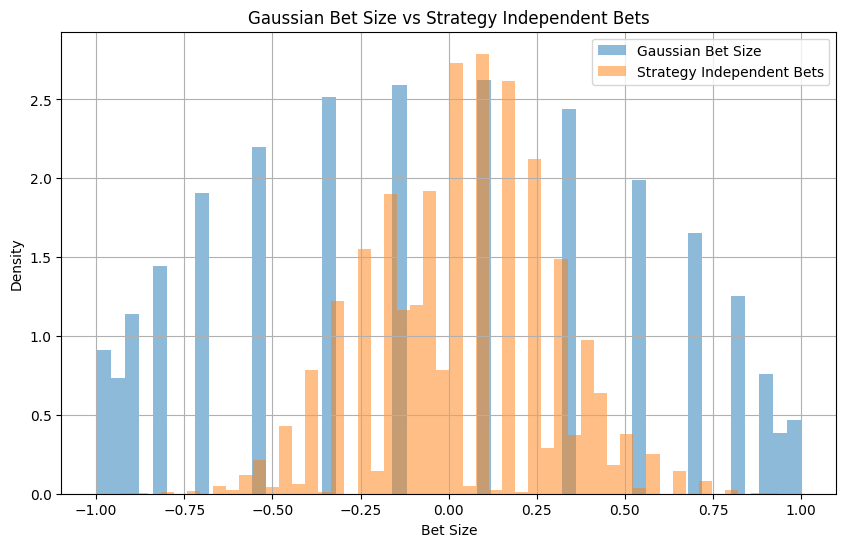


Strategy Independent Bets Skew: -0.04407870517738002
Concurrent Diff Skew: 0.11576811546509973
Strategy Independent Bets Kurtosis: -0.17586024444426762
Concurrent Diff Kurtosis: -1.265005074011538


In [36]:

from scipy.stats import skew, kurtosis
plt.figure(figsize=(10, 6))
plt.title('Gaussian Bet Size vs Strategy Independent Bets')
plt.xlabel('Bet Size')
plt.ylabel('Density')
plt.hist(X['gaussian_bet_size'], bins=50, alpha=0.5, label='Gaussian Bet Size', density=True)
plt.hist(X['strategy_independent_bets'], bins=50, alpha=0.5, label='Strategy Independent Bets', density=True)
plt.legend()
plt.grid()
plt.show()
print("")

print("Strategy Independent Bets Skew:", skew(X['strategy_independent_bets']))
print("Concurrent Diff Skew:", skew(X['gaussian_bet_size']))
print("Strategy Independent Bets Kurtosis:", kurtosis(X['strategy_independent_bets']))
print("Concurrent Diff Kurtosis:", kurtosis(X['gaussian_bet_size']))

10.5 Repeat exercise 1, where you discretize m with a stepSize=0.01,
stepSize=0.05,and stepSize=0.1

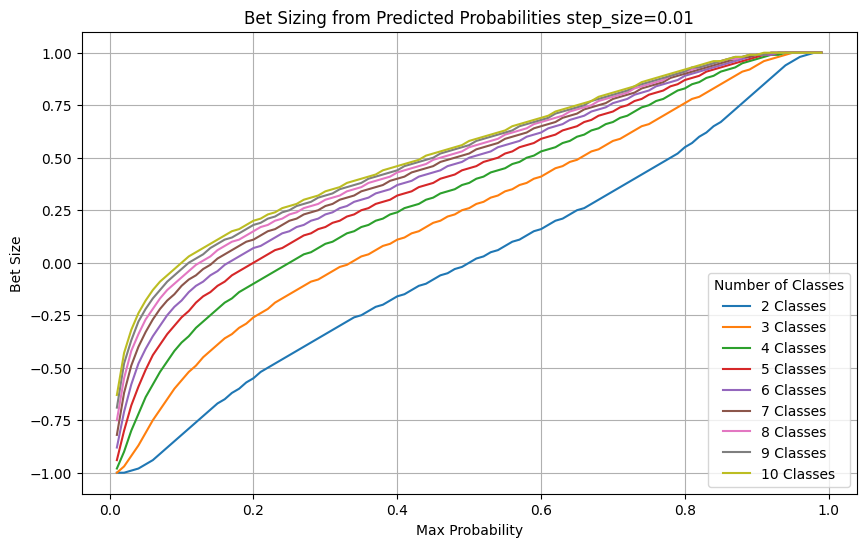

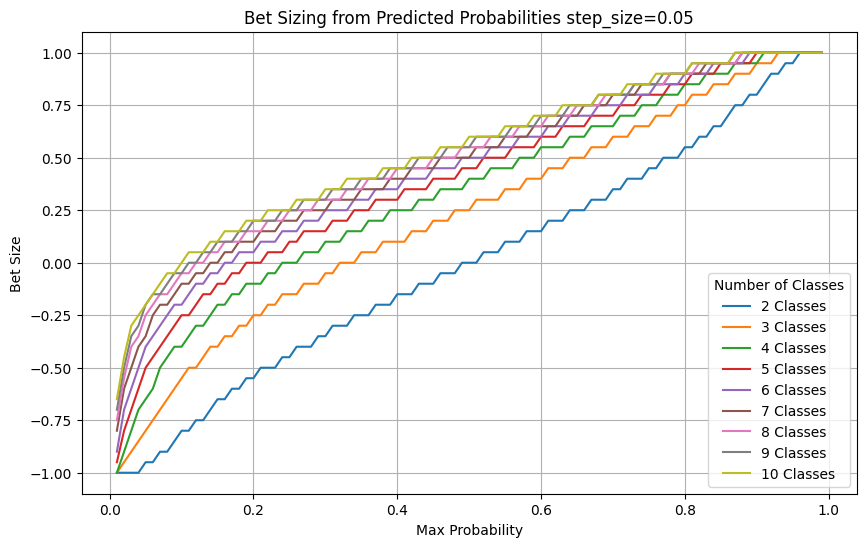

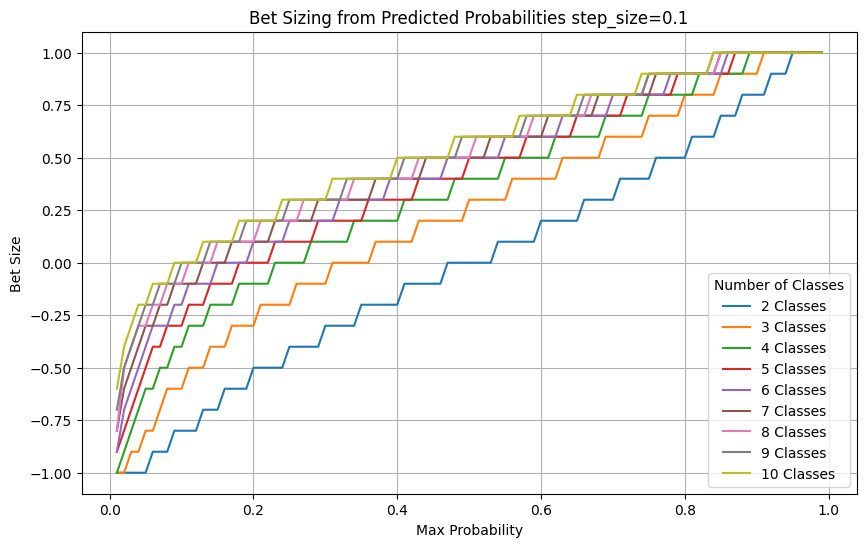

In [29]:
def discreate_signal(series:pd.Series, step_size=0.1):
    """
    Discretize a continuous signal into discrete steps.
    """
    series=np.round(series/step_size)*step_size
    series[series>1]=1
    series[series<-1]=-1
    return series

for step_size in [0.01, 0.05, 0.1]:
    plt.figure(figsize=(10, 6))
    plt.title(f'Bet Sizing from Predicted Probabilities step_size={step_size}')
    plt.xlabel('Max Probability')
    plt.ylabel('Bet Size')
    for i in range(2, 11):
        plt.plot(max_p_range, discreate_signal(df[i], step_size), label=f'{i} Classes')
    plt.legend(title='Number of Classes')
    plt.grid()
    plt.show()

10.6 Rewrite the equations in Section 10.6, so that the bet size is determined by a  
power function rather than a sigmoidfunction.  

10.7 Modify Snippet 10.4 so that it implements the equations you derived in exercise6.

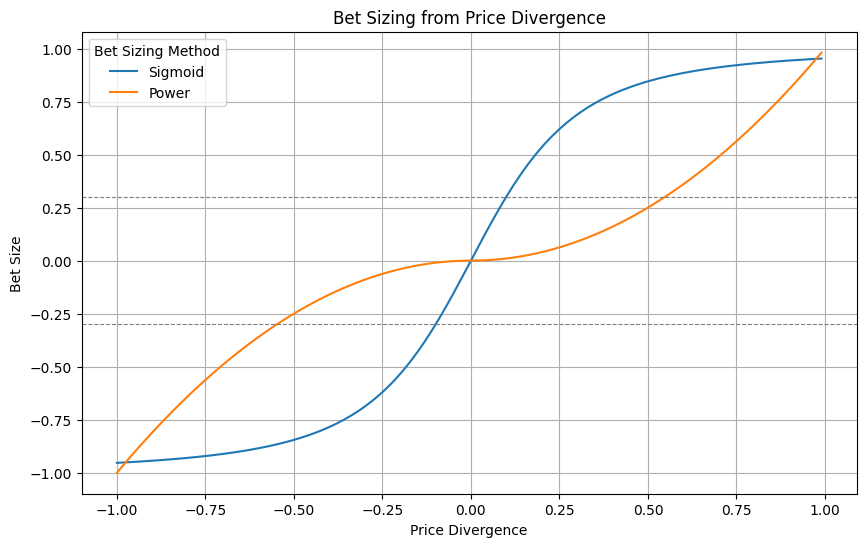

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

def get_bet_size_sigmoid(width, price_divergence):
    return price_divergence / math.sqrt(width + price_divergence**2)

def get_bet_size_sigmoid_width(price_divergence: float, target_bet_size: float): # 쓰면 폭발함
    '''
    Inverse of bet_size_sigmoid with respect to width
    '''
    return price_divergence**2 * (pow(target_bet_size, -2) - 1)

def get_bet_size_power(width, price_divergence):
    return np.sign(price_divergence) * np.abs(price_divergence)**width

def get_bet_size_power_width(price_divergence: float, target_bet_size: float):  # 쓰면 폭발함
    '''
    Inverse of bet_size_power with respect to width
    '''
    return np.log(np.abs(target_bet_size)) / np.log(np.abs(price_divergence))

# Filter out zero to avoid log(0) in inverse
price_divergence = np.arange(-1, 1, 0.01)
price_divergence = price_divergence[price_divergence != 0]
target_bet_size = 0.3

bet_size_sigmoid = []
bet_size_power = []

for i in price_divergence:
    try:
        b_sig = get_bet_size_sigmoid(0.1, i)
        bet_size_sigmoid.append(b_sig)
    except:
        bet_size_sigmoid.append(np.nan)

    try:
        b_pow = get_bet_size_power(2, i)
        bet_size_power.append(b_pow)
    except:
        bet_size_power.append(np.nan)

plt.figure(figsize=(10, 6))
plt.title('Bet Sizing from Price Divergence')
plt.xlabel('Price Divergence')
plt.ylabel('Bet Size')
plt.plot(price_divergence, bet_size_sigmoid, label='Sigmoid')
plt.plot(price_divergence, bet_size_power, label='Power')
plt.axhline(y=target_bet_size, color='gray', linestyle='--', linewidth=0.8)
plt.axhline(y=-target_bet_size, color='gray', linestyle='--', linewidth=0.8)
plt.legend(title='Bet Sizing Method')
plt.grid(True)
plt.show()
